In [3]:
'''
import gensim.downloader as api
import pandas as pd

wv = api.load('word2vec-google-news-300')

df = pd.read_csv('qqpTrain.csv')

data = df.to_dict(orient='records')

data = data[:3500]
newData = []
bm25Query = []
bm25Answer = []
for idx1,d1 in enumerate(data):
    bm25Query.append(d1["question1"])
    bm25Answer.append(d1["question2"])
    for idx2,d2 in enumerate(data):
        isDuplicate = 0
        if idx1 == idx2 and d1["is_duplicate"] == 1:
            isDuplicate = 1
        newData.append({"question1":d1['question1'],"question2":d2['question2'],"is_duplicate":isDuplicate})
data = newData
'''


In [3]:
from scipy import spatial
import numpy as np
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [1]:
import os
import csv
dataset_path = 'quora-dataset/'
first5000 = []
with open(os.path.join(dataset_path, 'classification', 'test_pairs.tsv'), 'r', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if len(first5000) >= 5000:
            break
        first5000.append((row['question1'], row['question2'], row['is_duplicate']))

pairs = []
for Iidx in range(len(first5000)):
    for Jidx in range(len(first5000)):
        label = 0
        if Iidx == Jidx and first5000[2] == 1:
            label = 1
        pairs.append((first5000[Iidx][0], first5000[Jidx][1], label))


In [4]:
import gensim.downloader as api
import pandas as pd

wv = api.load('word2vec-google-news-300')

w2vResult = []
invalidList = set() #sync data between w2v and bm25
try:
    for idx,d in enumerate(pairs):
        if type(d[0]) != str or type(d[1]) != str:
            invalidList.add(idx)
            continue

        query = []
        answer = []
        for q in tokenizer.tokenize(d[0]):
            if q in wv:
                query.append(wv[q])
        for a in tokenizer.tokenize(d[1]):
            if a in wv:
                answer.append(wv[a])
        if not query or not answer:
            invalidList.add(idx)
            continue
        query = np.max(np.array(query),0)
        answer = np.max(np.array(answer),0)

        doc_scores = 1 - spatial.distance.cosine(query, answer)
        w2vResult.append((doc_scores, d[2]))
        
except Exception as e:
    print(e)


import pickle

# Define the file path
file_path = "qqp5000w2v.pkl"

# Serialize and save the list to a binary file using pickle
with open(file_path, "wb") as file:
    pickle.dump(w2vResult, file)

In [4]:
'''
arr = wv[['United','States']]
#arr = np.max(arr,0)
print(arr.shape)
q = wv['United_States']
p = wv['bus']
x = wv['car']
print(1 - spatial.distance.cosine(p, x))
'''

(2, 300)
0.4693371057510376


In [9]:
'''
import gensim.downloader as api
import pandas as pd

wv = api.load('word2vec-google-news-300')

w2vResult = []
invalidList = set() #sync data between w2v and bm25
try:
    for idx,d in enumerate(data):
        if type(d['question1']) != str or type(d['question2']) != str:
            invalidList.add(idx)
            continue

        query = []
        answer = []
        for q in tokenizer.tokenize(d['question1']):
            if q in wv:
                query.append(wv[q])
        for a in tokenizer.tokenize(d['question2']):
            if a in wv:
                answer.append(wv[a])
        if not query or not answer:
            invalidList.add(idx)
            continue
        query = np.max(np.array(query),0)
        answer = np.max(np.array(answer),0)

        doc_scores = 1 - spatial.distance.cosine(query, answer)
        w2vResult.append((doc_scores, d['is_duplicate']))
        if d['is_duplicate'] == 1:
            print(doc_scores)
except Exception as e:
    print(e)


import pickle

# Define the file path
file_path = "qqp5000w2v.pkl"

# Serialize and save the list to a binary file using pickle
with open(file_path, "wb") as file:
    pickle.dump(w2vResult, file)
'''

0.9223142862319946
0.9592598676681519
0.9643203616142273
0.9152286052703857
0.9943414926528931
0.91750568151474
0.9785944819450378
0.9729781150817871
0.9179036021232605
0.9456987380981445
0.9375271201133728
0.9935175776481628
0.8459294438362122
0.9688063859939575
0.9608551859855652
0.9407669901847839
0.9668905138969421
0.9557984471321106
0.9573115110397339
0.9032690525054932
0.8853861689567566
0.9373457431793213
0.9343193769454956
1
0.9792497158050537
0.8405161499977112
0.9995918273925781
0.9455393552780151
0.9100388884544373
0.8995740413665771
0.9638261198997498
0.9753886461257935
0.9422059655189514
0.8814143538475037
0.9870768189430237
0.9175605177879333
0.9628064632415771
0.971851646900177
0.9306150674819946
0.927030086517334
0.9536852240562439
0.8995647430419922
0.9511639475822449
0.9774759411811829
0.9462135434150696
0.967560350894928
0.9064681529998779
0.93673175573349
0.9587677121162415
0.8907597064971924
0.9725919365882874
0.9822223782539368
0.970236599445343
0.8713744878768921

In [8]:
import pickle
# Define the file path
file_path = "qqp3500w2v.pkl"
w2vResult = None
# Read the list from the binary file using pickle
with open(file_path, "rb") as file:
    w2vResult = pickle.load(file)



file_path = "qqp3500bm25P.pkl"
bm25Result = None
# Read the list from the binary file using pickle
with open(file_path, "rb") as file:
    bm25Result = pickle.load(file)

In [9]:
print(len(w2vResult))
print(len(bm25Result))

12246500
12250000


In [13]:
counter = 0
for idx in range(len(newList)):
    if newList[idx] == w2vResult[idx]:
        counter += 1
print(counter)

12246500


In [11]:
def measure(result,threshold):
    counter = 0
    negCounter = 0
    totalDuplicatePredicted = 0
    totalScore = 0
    #threshold = -2 #0.1   -2
    for r in result:
        if r[0] >= threshold and r[1] == 1:
            counter += 1
        if r[0] < threshold and r[1] == 0:
            negCounter += 1
        if r[0] >= threshold:
            totalDuplicatePredicted += 1
        totalScore += r[0]
    if totalDuplicatePredicted == 0:
        return 0., negCounter/(len(result)-totalDuplicatePredicted),(counter+negCounter)/len(result)
    if totalDuplicatePredicted == len(result):
        return counter/totalDuplicatePredicted, 0.,(counter+negCounter)/len(result)
    return counter/totalDuplicatePredicted, negCounter/(len(result)-totalDuplicatePredicted),(counter+negCounter)/len(result)

In [30]:
from functools import cmp_to_key

def compareTuple(a,b):
    return a[0] - b[0]

def intervalMeasure(result, scoreList):
    result = sorted(result,key = cmp_to_key(compareTuple))
    resultIdx = 0
    ret = []
    while result[resultIdx][0] < scoreList[0] - (scoreList[1] - scoreList[0]): #so the first interval won't be zero
        resultIdx += 1
    for idx, score in enumerate(scoreList):
        
        curPos = 0
        curTotal = 0
        while resultIdx < len(result) and result[resultIdx][0] < score:
            if result[resultIdx][1] == 1:
                curPos += 1
            curTotal += 1
            resultIdx += 1
        if curTotal == 0:
                ret.append(0.0)
                continue
        ret.append(curPos/curTotal)
    
    return ret


In [49]:
w2vxAxis = np.linspace(0.94,1.005,50).tolist()
w2vIntervalPos = intervalMeasure(w2vResult,w2vxAxis)

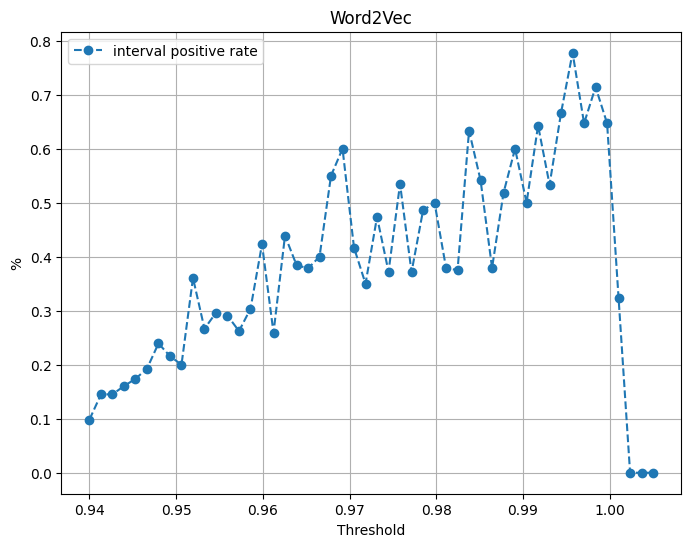

In [50]:
import numpy as np
import matplotlib.pyplot as plt
x_values = w2vxAxis  # X-axis values


# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(x_values, w2vIntervalPos, label='interval positive rate', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Threshold')
plt.ylabel('%')
plt.title('Word2Vec')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()

0.9998937655656718


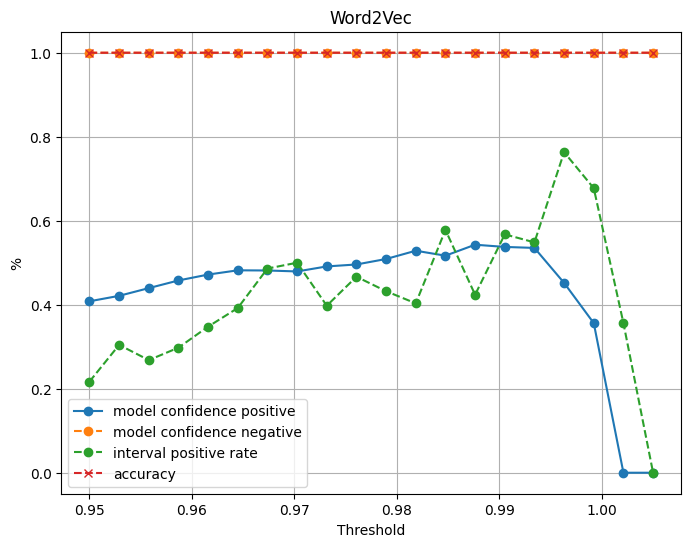

In [32]:
'''
import numpy as np
import matplotlib.pyplot as plt

#w2vxAxis = np.linspace(0.95,1.005,20).tolist()
w2vtruePos = []
w2vtrueNeg = []
w2vAccuracy = []
#w2vIntervalPos = intervalMeasure(w2vResult,w2vxAxis)
for threshold in w2vxAxis:
    tp,tn,ac = measure(w2vResult,threshold)
    w2vtruePos.append(tp)
    w2vtrueNeg.append(tn)
    w2vAccuracy.append(ac)

print(max(w2vAccuracy))
# Sample data
x_values = w2vxAxis  # X-axis values
y1_values = w2vtruePos  # First set of Y-axis values
y2_values = w2vtrueNeg  # Second set of Y-axis values

# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(x_values, y1_values, label='model confidence positive', marker='o', linestyle='-')
plt.plot(x_values, y2_values, label='model confidence negative', marker='o', linestyle='--')
plt.plot(x_values, w2vIntervalPos, label='interval positive rate', marker='o', linestyle='--')
plt.plot(x_values, w2vAccuracy, label='accuracy', marker='x', linestyle='--')

# Add labels and a legend
plt.xlabel('Threshold')
plt.ylabel('%')
plt.title('Word2Vec')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()
'''

In [51]:
w2vResult.sort(reverse=True)

In [171]:
cutOffacc = w2vxAxis[0] - (w2vxAxis[1]-w2vxAxis[0])
cutOffList = []
for result in w2vResult:
    if result[0] > cutOffacc:
        cutOffList.append(result)
        continue
    break
weight = []
curWeightIdx = 0
cutOffList.reverse()
for c in cutOffList:
    while c[0] >= w2vxAxis[curWeightIdx]:
        curWeightIdx += 1
        #print(curWeightIdx)
    weight.append(w2vIntervalPos[curWeightIdx])
print(len(cutOffList))

2333


In [416]:
print(len(weight))


2333


In [417]:
import random
expectation = 0
sumWeight = sum(weight)
for idx in range(len(cutOffList)):
    expectation += weight[idx] * weight[idx] / sumWeight

print(expectation)
#print(f"Mean: {mean_value}")
#print(f"Variance: {variance_value}")



0.39258068144204


In [ ]:
(2333/expectation)/()

0.00641931855795997
-0.00798068144203999
-0.0014806814420400003
0.0013993185579600034
0.00021931855795999632
0.0005233185579599992
5.631855796000201e-05


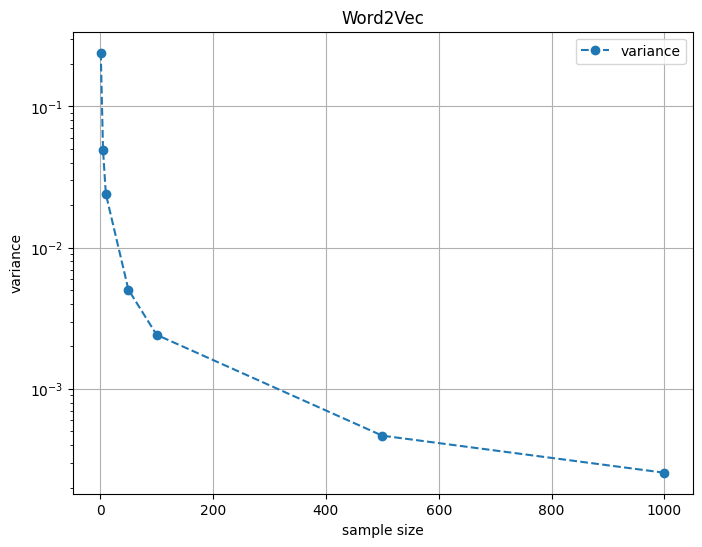

In [415]:
numSampleList = [1,5,10,50,100,500,1000]
varianceList = []
for numSample in numSampleList:
    sampleResult = []
    numTrail = 1000
    for i in range(numTrail):
        sample = random.choices(cutOffList,weight,k=numSample)
        posCount = 0
        for s in sample:
            if s[1] == 1:
                posCount += 1
        sampleResult.append(posCount/ len(sample) - expectation)



    mean_value = np.mean(sampleResult)
    print(mean_value)

    # Calculate the variance
    variance_value = np.var(sampleResult)
    varianceList.append(variance_value)

# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(numSampleList, varianceList, label='variance', marker='o', linestyle='--')
plt.yscale('log')
# Add labels and a legend
plt.xlabel('sample size')
plt.ylabel('variance')
plt.title('Word2Vec')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()

4028


In [10]:
negativeScore = []
positiveScore = []
bestAcc = 0
bestAccIdx = 0
for idx,acc in enumerate(w2vAccuracy):
    if acc > bestAcc:
        bestAcc = acc
        bestAccIdx = idx
bestThreshold = w2vxAxis[bestAccIdx]

for r in w2vResult:
    if r[1] == 1:
        positiveScore.append(r[0])
    else:
        negativeScore.append(r[0])

positiveScore.sort()
negativeScore.sort()


In [11]:
def cutOff(MOE, bestThreshold):
    posCutOff = 0
    posInAccurateCount = 0
    negCutOff = 0
    negInAccurateCount = 0
    for idx, s in enumerate(reversed(positiveScore)):
        if s < bestThreshold:
            posInAccurateCount += 1
        if posInAccurateCount / max(idx,100) > MOE:
            posCutOff = idx
            break
    if posCutOff == 0:
        posCutOff = len(positiveScore)

    for idx, s in enumerate(negativeScore):
        if s >= bestThreshold:
            negInAccurateCount += 1
        if negInAccurateCount / max(idx,100) > MOE:
            negCutOff = idx
            break
    if negCutOff == 0:
        negCutOff = len(positiveScore)

    return (negCutOff+posCutOff)/len(w2vResult)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.7957581859244399, 0.7924286537657602, 0.7891288054004715, 0.7858512198802259, 0.7826033181533713, 0.7793851002199075, 0.7761916187809361, 0.7730228738364572, 0.7698788653864707, 0.766764540729875, 0.7636700052688733, 0.7606051536012626, 0.757562564778695, 0.7545422388011706, 0.751551596617037, 0.7485807436284975, 0.745632153485001, 0.7427082998359971, 0.7398067090320363, 0.7369273810731186, 0.7340703159592441, 0.7312355136904128, 0.728425447916074, 0.7256351713373291, 0.7228646839541781, 0.7201164594160703, 0.7173880240735564, 0.7146818515760858, 0.7119929946247597, 0.7093288741679261, 0.706679595607788, 0.7040525798926931, 0.701445353373192, 0.698857916049285, 0.6962902679209718, 0.6937374616893541, 0.6912044446533304, 0.6886936904623499, 0.6861977781680647, 0.6837216550693735, 0.6812603738673778, 0.6788188818609759, 0.676397179050168, 0.7384486754844024, 0.7384486754844024, 0.7384486754844024, 0.7384486754844024, 0.7384486754844024, 0.7384486754844024, 0.7384486754844024]


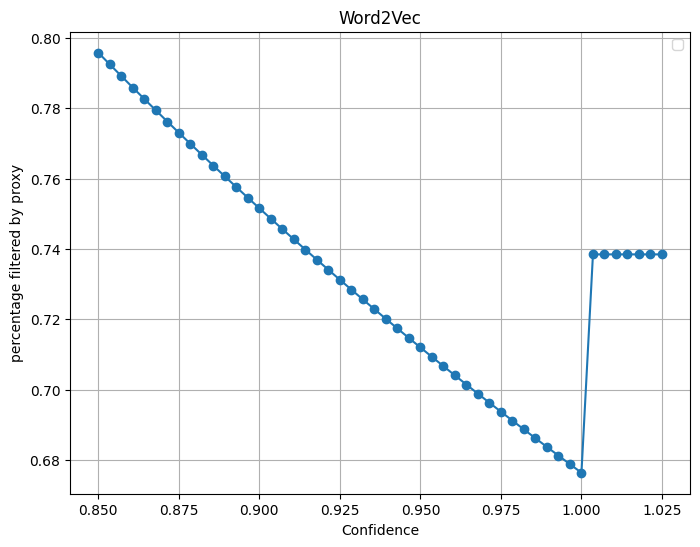

In [12]:
filterPercentage = []
for confidence in w2vxAxis:
    filterPercentage.append(cutOff(MOE=1-confidence,bestThreshold=bestThreshold))
print(filterPercentage)
# Sample data
x_values = w2vxAxis  # X-axis values
y_values = filterPercentage  # First set of Y-axis values

# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(x_values, y_values, marker='o', linestyle='-')


# Add labels and a legend
plt.xlabel('Confidence')
plt.ylabel('percentage filtered by proxy')
plt.title('Word2Vec')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()


In [10]:
def bm25measure(bm25Result,threshold):
    counter = 0
    negCounter = 0
    totalDuplicatePredicted = 0
    totalScore = 0
    #threshold = -2 #0.1   -2
    for r in bm25Result:  #positive result have negative score
        if r[0] <= threshold and r[1] == 1:
            counter += 1
        if r[0] > threshold and r[1] == 0:
            negCounter += 1
        if r[0] <= threshold:
            totalDuplicatePredicted += 1
        
        totalScore += r[0]
        #P(Label = True | model = True)
    if totalDuplicatePredicted == 0:
        return 1, negCounter/(len(bm25Result)-totalDuplicatePredicted), totalScore
        
    if totalDuplicatePredicted == len(bm25Result):
        return counter/totalDuplicatePredicted, 1, totalScore
    
    return counter/totalDuplicatePredicted, negCounter/(len(bm25Result)-totalDuplicatePredicted), totalScore

In [15]:
from rank_bm25 import BM25Okapi
tokenized_answer = [doc.split(" ") for doc in bm25Answer]
tokenized_question = [doc.split(" ") for doc in bm25Query]
bm25 = BM25Okapi(tokenized_answer)

doc_scores = bm25.get_scores(tokenized_query)
bm25result = 
print(doc_scores)
#doc_scores = bm25.get_scores(tokenized_question)


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

0.6880221672704305


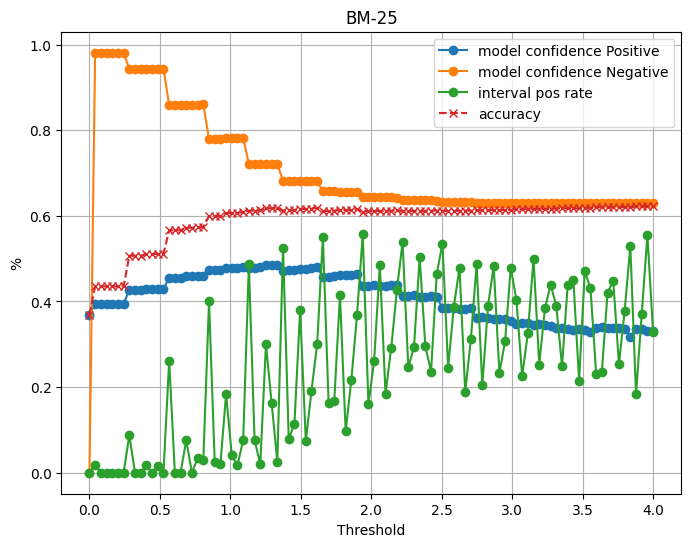

In [15]:
import matplotlib.pyplot as plt

bm25xAxis = np.linspace(0,4,100).tolist()
bm25truePos = []
bm25trueNeg = []
bm25Accuracy = []
for threshold in bm25xAxis:
    tp,tn,ac = measure(bm25Result,threshold)
    bm25truePos.append(tp)
    bm25trueNeg.append(tn)
    bm25Accuracy.append(ac)
bm25IntervalPos = intervalMeasure(bm25Result,bm25xAxis)

# Sample data
x_values = bm25xAxis  # X-axis values
y1_values = bm25truePos  # First set of Y-axis values
y2_values = bm25trueNeg  # Second set of Y-axis values
accuracy = [(y1+y2)/2 for y1,y2 in zip(y1_values,y2_values)]
print(max(accuracy))
# Create the line graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(x_values, y1_values, label='model confidence Positive', marker='o', linestyle='-')
plt.plot(x_values, y2_values, label='model confidence Negative', marker='o', linestyle='-')
plt.plot(x_values, bm25IntervalPos, label='interval pos rate', marker='o', linestyle='-')
plt.plot(x_values, bm25Accuracy, label='accuracy', marker='x', linestyle='--')

# Add labels and a legend
plt.xlabel('Threshold')
plt.ylabel('%')
plt.title('BM-25')
plt.legend()

# Show the graph (or save it to a file with plt.savefig)
plt.grid(True)  # Optional: Show grid lines
plt.show()


In [16]:
bestAccIdx = 0
for idx,acc in enumerate(bm25Accuracy):
    if acc > bestAcc:
        bestAcc = acc
        bestAccIdx = idx
bestThresholdbm25 = bm25xAxis[bestAccIdx]


In [17]:
def binarySearch(score, confidenceList, rangeList):
	if score > rangeList[-1]:
		return confidenceList[-1]
	if score < rangeList[0]:
		return confidenceList[0]

	highIdx = len(confidenceList) - 1 
	lowIdx = 0
	while highIdx - lowIdx > 1:
		midIdx = (highIdx+lowIdx) // 2
		midScore = rangeList[midIdx]
		if score >= midScore:
			lowIdx = midIdx
		elif score < midScore:
			highIdx = midIdx

	lowScore = rangeList[lowIdx]
	highScore = rangeList[highIdx]
	if score > highScore or score < lowScore or highIdx - lowIdx > 1:
		print("ERR")
		return None
	toLowPercent = (score-lowScore) / (highScore-lowScore)
	return confidenceList[lowIdx] * toLowPercent + confidenceList[highIdx] * (1-toLowPercent)
    

In [18]:
# A: L=True   B: X=L

newResult = []
for idx in range(len(w2vResult)):
    w2vPos = binarySearch(w2vResult[idx][0],w2vIntervalPos,w2vxAxis)
    #w2vNeg = binarySearch(w2vResult[idx][0],w2vtrueNeg,w2vxAxis)
    bm25Pos = binarySearch(bm25Result[idx][0],bm25IntervalPos,bm25xAxis)
    #bm25Neg = binarySearch(bm25Result[idx][0],bm25trueNeg,bm25xAxis)
    maxPos = max(w2vPos,bm25Pos)
    #maxNeg = max(w2vNeg,bm25Neg)
    #p = maxPos / (maxPos + maxNeg)
    wtp = 0.4450466626022524
    wtn = 0.6858838108534184
    btp = 0.28199218828510747
    btn = 0.7979670428787676
    #p = w2vPos
    #if w2vResult[idx][0] < bestThreshold:
        
    #label = np.random.choice([0, 1], size=1, p=[1 - p, p])[0]

    
    
    label = 0
    if bm25Pos >= 0.5:
        label = 1
    #'''
    if w2vPos >= 0.5 and bm25Pos >= 0.5:
        label = 1
    if w2vPos < 0.5 and bm25Pos < 0.5:
        label = 0
    else:
        if bm25Pos >= 0.5:
            p = bm25Pos / (bm25Pos + (1-w2vPos))
            label = np.random.choice([0, 1], size=1, p=[1 - p, p])[0]
        else:
            p = w2vPos / (w2vPos + (1-bm25Pos))
            label = np.random.choice([0, 1], size=1, p=[1 - p, p])[0]
    #'''
        
    newResult.append((label,w2vResult[idx][1]))    

In [23]:
def combinedMeasure(result):
    counter = 0
    negCounter = 0
    totalDuplicate = 0
    totalScore = 0
    #threshold = -2 #0.1   -2
    for r in result:  #positive result have negative score
        if r[0] == 1 and r[1] == 1:
            counter += 1
        if r[0] == 0 and r[1] == 0:
            negCounter += 1
        if r[1] == 1:
            totalDuplicate += 1
        totalScore += r[0]
    return counter/totalDuplicate, negCounter/(len(result)-totalDuplicate),(counter + negCounter) / len(result)

In [33]:
#w2v only
print(combinedMeasure(newResult))

(0.4450466626022524, 0.6858838108534184, 0.5969608742866613)


In [24]:
#w2v only absolute
print(combinedMeasure(newResult))

(0.47893985783482845, 0.7907513000101961, 0.6756229267725553)


In [26]:
print(combinedMeasure(newResult))

(0.22430207084140075, 0.900630593181123, 0.6509136424240776)


In [79]:
print(combinedMeasure(newResult))

(0.42764784306894543, 0.6180283766931506, 0.5477352502467465)


In [91]:
#random
print(combinedMeasure(newResult))

(1.0, 0.0, 0.3692243377422012)


In [40]:
#bm25only
print(combinedMeasure(newResult))

(0.28199218828510747, 0.7979670428787676, 0.6074565688997949)
